# Imports

In [5]:
from main import *
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from pythonmetar.metar import Metar

sns.set_style('whitegrid')

# BIMTRA

## Dataset import from API

In [9]:
INICIAL_DATE = '2022-06-01'
FINAL_DATE = '2023-05-13'

# Get BIMTRA data from API
df_bimtra_raw = request_api(endpoint='bimtra', inicial_date=INICIAL_DATE, final_date=FINAL_DATE)

In [10]:
df_bimtra_raw['deltaT'] = df_bimtra_raw['dt_arr']-df_bimtra_raw['dt_dep']

df_bimtra_raw[['dt_dep','dt_arr']] = df_bimtra_raw[['dt_dep','dt_arr']]/1000

df_bimtra_raw['dt_dep'] = pd.to_datetime(df_bimtra_raw['dt_dep'], unit ='s')

df_bimtra_raw['hora_ref'] = df_bimtra_raw['dt_dep'].dt.floor('H')

df_bimtra_raw['hora_esperas'] = df_bimtra_raw['hora_ref'] - pd.to_timedelta('1 hour')

df_bimtra_raw['hora_metaf'] = df_bimtra_raw['hora_ref'] + pd.to_timedelta('1 hour')

df_bimtra_raw['hora_metar']  = df_bimtra_raw['hora_ref']

df_bimtra_raw['hora_tcp'] = df_bimtra_raw['hora_ref'] + pd.to_timedelta('1 hour')

df_bimtra_raw

,flightid,origem,destino,dt_dep,dt_arr,deltaT,hora_ref,hora_esperas,hora_metaf,hora_metar,hora_tcp
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,1.654047e+09,2463000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,1.654047e+09,2152000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,1.654048e+09,4613000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,1.654048e+09,2581000,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547000,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 02:00:00,2022-06-01 01:00:00,2022-06-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...
300342,c4321a6a09b76969df53965fb5390f12,SBBR,SBRF,2023-05-13 12:14:19,1.683988e+09,7564000,2023-05-13 12:00:00,2023-05-13 11:00:00,2023-05-13 13:00:00,2023-05-13 12:00:00,2023-05-13 13:00:00
300343,e4f5686cce45083566945c8946e5d120,SBBR,SBGR,2023-05-13 09:33:15,1.683976e+09,5126000,2023-05-13 09:00:00,2023-05-13 08:00:00,2023-05-13 10:00:00,2023-05-13 09:00:00,2023-05-13 10:00:00
300344,04f65a7c44cf176215520b4c9b4eb37f,SBCF,SBRF,2023-05-13 16:53:53,1.684004e+09,7591000,2023-05-13 16:00:00,2023-05-13 15:00:00,2023-05-13 17:00:00,2023-05-13 16:00:00,2023-05-13 17:00:00
300345,f72a0718e581d01c695faeeff35d81f0,SBSV,SBGR,2023-05-13 05:28:58,1.683964e+09,8743000,2023-05-13 05:00:00,2023-05-13 04:00:00,2023-05-13 06:00:00,2023-05-13 05:00:00,2023-05-13 06:00:00


# ESPERAS

In [11]:
# Get ESPERAS DE VOOS data from API
df_esperas = request_api(endpoint='esperas', inicial_date=INICIAL_DATE, final_date=FINAL_DATE)

df_esperas[df_esperas['esperas']!=0]

,esperas,hora,aero
548,1,1656014400000,SBBR
902,1,1657288800000,SBBR
1237,3,1658494800000,SBBR
1305,1,1658739600000,SBBR
1323,1,1658804400000,SBBR
...,...,...,...
99423,2,1682175600000,SBSV
99447,1,1682262000000,SBSV
99495,1,1682434800000,SBSV
99880,3,1683820800000,SBSV


In [12]:
df_esperas['hora'] = df_esperas['hora']/1000

df_esperas['hora'] = pd.to_datetime(df_esperas['hora'], unit ='s')

df_esperas

,esperas,hora,aero
0,0,2022-06-01 00:00:00,SBBR
1,0,2022-06-01 01:00:00,SBBR
2,0,2022-06-01 02:00:00,SBBR
3,0,2022-06-01 03:00:00,SBBR
4,0,2022-06-01 04:00:00,SBBR
...,...,...,...
99931,0,2023-05-13 19:00:00,SBSV
99932,0,2023-05-13 20:00:00,SBSV
99933,0,2023-05-13 21:00:00,SBSV
99934,0,2023-05-13 22:00:00,SBSV


# METAF

In [13]:
# Get METAF data from API
df_metaf = request_api(endpoint='metaf', inicial_date=INICIAL_DATE, final_date=FINAL_DATE)

df_metaf

,hora,metaf,aero
0,1659657600000,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,1659661200000,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,1659664800000,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,1659668400000,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,1659672000000,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,1684004400000,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,1684008000000,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,1684011600000,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,1684015200000,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


In [14]:
df_metaf['hora'] = df_metaf['hora']/1000

df_metaf['hora'] = pd.to_datetime(df_metaf['hora'], unit ='s')

df_metaf

,hora,metaf,aero
0,2022-08-05 00:00:00,METAF SBBR 050000Z 05006KT CAVOK 18/04 Q1014=\n,SBBR
1,2022-08-05 01:00:00,METAF SBBR 050100Z 01006KT CAVOK 17/05 Q1016=\n,SBBR
2,2022-08-05 02:00:00,METAF SBBR 050200Z 35008KT CAVOK 17/05 Q1014=\n,SBBR
3,2022-08-05 03:00:00,METAF SBBR 050300Z 34007KT CAVOK 16/05 Q1015=\n,SBBR
4,2022-08-05 04:00:00,METAF SBBR 050400Z 34008KT CAVOK 16/05 Q1015=\n,SBBR
...,...,...,...
43933,2023-05-13 19:00:00,METAF SBSP 131900Z 14010KT 9999 OVC024 ...,SBSP
43934,2023-05-13 20:00:00,METAF SBSP 132000Z 14009KT 9999 BKN033 ...,SBSP
43935,2023-05-13 21:00:00,METAF SBSP 132100Z 14008KT 8000 OVC033 ...,SBSP
43936,2023-05-13 22:00:00,METAF SBSP 132200Z 14007KT 7000 OVC033 ...,SBSP


# METAR

In [15]:
# Get METAR data from API
df_metar = request_api(endpoint='metar', inicial_date=INICIAL_DATE, final_date=FINAL_DATE)

df_metar

,hora,metar,aero
0,1654041600000,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,1654045200000,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,1654048800000,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,1654052400000,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,1654056000000,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,1684004400000,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,1684008000000,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,1684011600000,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,1684015200000,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


In [16]:
df_metar['hora'] = df_metar['hora']/1000

df_metar['hora'] = pd.to_datetime(df_metar['hora'], unit ='s')

df_metar

,hora,metar,aero
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018=,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019=,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019=,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019=,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018=,SBBR
...,...,...,...
106739,2023-05-13 19:00:00,METAR SBSV 131900Z 16009KT 9999 BKN020 FEW021T...,SBSV
106740,2023-05-13 20:00:00,METAR SBSV 132000Z 13007KT 9999 BKN020 29/24 Q...,SBSV
106741,2023-05-13 21:00:00,METAR SBSV 132100Z 12005KT 9999 SCT020 FEW025T...,SBSV
106742,2023-05-13 22:00:00,METAR SBSV 132200Z 11006KT 9999 SCT020 FEW025T...,SBSV


# TC Prev


In [17]:
# Get TROCAS PREVISÃO data from API
df_tcprev = request_api(endpoint='tc-prev', inicial_date=INICIAL_DATE, final_date=FINAL_DATE)

df_tcprev

,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR
...,...,...,...
99931,1684004400000,0,SV
99932,1684008000000,0,SV
99933,1684011600000,0,SV
99934,1684015200000,0,SV


In [18]:
df_tcprev['hora'] = df_tcprev['hora']/1000

df_tcprev['hora'] = pd.to_datetime(df_tcprev['hora'], unit ='s')

df_tcprev['aero'] = 'SB' + df_tcprev['aero']

df_tcprev[df_tcprev['troca']!=0]

,hora,troca,aero
15,2022-06-01 15:00:00,1,SBBR
16,2022-06-01 16:00:00,1,SBBR
17,2022-06-01 17:00:00,1,SBBR
18,2022-06-01 18:00:00,1,SBBR
19,2022-06-01 19:00:00,1,SBBR
...,...,...,...
99909,2023-05-12 21:00:00,1,SBSV
99910,2023-05-12 22:00:00,1,SBSV
99911,2023-05-12 23:00:00,1,SBSV
99912,2023-05-13 00:00:00,1,SBSV


# Merge Data

In [19]:
data_raw = df_bimtra_raw.copy()

data_raw = data_raw.merge(df_esperas, left_on=['hora_esperas','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_esperas'))

data_raw = data_raw.merge(df_metaf[['hora','metaf','aero']], left_on=['hora_metaf','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_metaf'))

data_raw = data_raw.merge(df_metar[['hora','metar','aero']], left_on=['hora_metar','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_metar'))

data_raw = data_raw.merge(df_tcprev[['hora','troca','aero']], left_on=['hora_tcp','destino'], right_on=['hora','aero'], how='left', suffixes=('', '_tcp'))

data_raw = data_raw.set_index('flightid')

data_raw['distance'] = data_raw.apply(calcular_distancia, axis=1)
data_raw['deltaT']= data_raw['deltaT']/1000

data_raw.loc[data_raw['distance'] == 0, 'deltaT'] = 0

In [20]:
data_raw = data_raw[(data_raw['deltaT']>=0)&(data_raw['deltaT']<=36000)].copy()
data_raw.head()

,origem,destino,dt_dep,dt_arr,deltaT,hora_ref,hora_esperas,hora_metaf,hora_metar,hora_tcp,...,hora_metaf,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,distance
flightid,,,,,,,,,,,,,,,,,,,,,
fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,2022-06-01 00:44:57,1.654047e+09,2463.0,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,SBRJ,2022-06-01 01:00:00,0.0,SBRJ,406.747989
c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,2022-06-01 00:57:01,1.654047e+09,2152.0,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,SBRJ,2022-06-01 01:00:00,0.0,SBRJ,342.948013
3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,1.654048e+09,4613.0,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBRJ 010000Z 17006KT 9999 SCT025 OVC050 ...,SBRJ,2022-06-01 01:00:00,0.0,SBRJ,928.188661
8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,2022-06-01 00:58:40,1.654048e+09,2581.0,2022-06-01 00:00:00,2022-05-31 23:00:00,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 01:00:00,...,NaT,NaN,NaN,2022-06-01 00:00:00,METAR SBCF 010000Z 12006KT CAVOK 21/14 Q1018=,SBCF,2022-06-01 01:00:00,0.0,SBCF,498.208232
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,1.654051e+09,5547.0,2022-06-01 01:00:00,2022-06-01 00:00:00,2022-06-01 02:00:00,2022-06-01 01:00:00,2022-06-01 02:00:00,...,NaT,NaN,NaN,2022-06-01 01:00:00,METAR SBFL 010100Z 15005KT 9999 BKN030 13/07 Q...,SBFL,2022-06-01 02:00:00,0.0,SBFL,1007.982120


In [21]:
data_raw['hour_dep'] = data_raw['dt_dep'].dt.hour
data_raw['minute_dep'] = data_raw['dt_dep'].dt.minute
data_raw['hour_rounded'] = round((data_raw['hour_dep']*60 + data_raw['minute_dep'])/60, 0)
data_raw['hour_rounded'] = data_raw['hour_rounded'].astype('int')

mean_time_df = data_raw[['origem', 'destino','deltaT']].groupby(['origem', 'destino']).mean()
mean_time_by_hour = data_raw[['origem', 'destino',  'hour_rounded','deltaT']].groupby(['origem', 'destino', 'hour_rounded']).mean()


mean_time_df.rename({'deltaT': 'mean_flight_time'}, inplace=True, axis=1)
mean_time_by_hour.rename({'deltaT': 'mean_flight_time_by_hour'}, inplace=True, axis=1)

mean_time_by_hour

mean_flight_time_by_hour
origem destino hour_rounded                          
SBBR   SBCF    0                          3256.348485
               1                          3265.491468
               2                          3220.586667
               3                          3173.000000
               4                          3257.666667
...                                               ...
SBSV   SBSP    18                         8299.708571
               19                         8247.619946
               20                         8190.613065
               21                         8169.207547
               22                         7922.055556

[2320 rows x 1 columns]

temperature
wind_dir
wind_speed


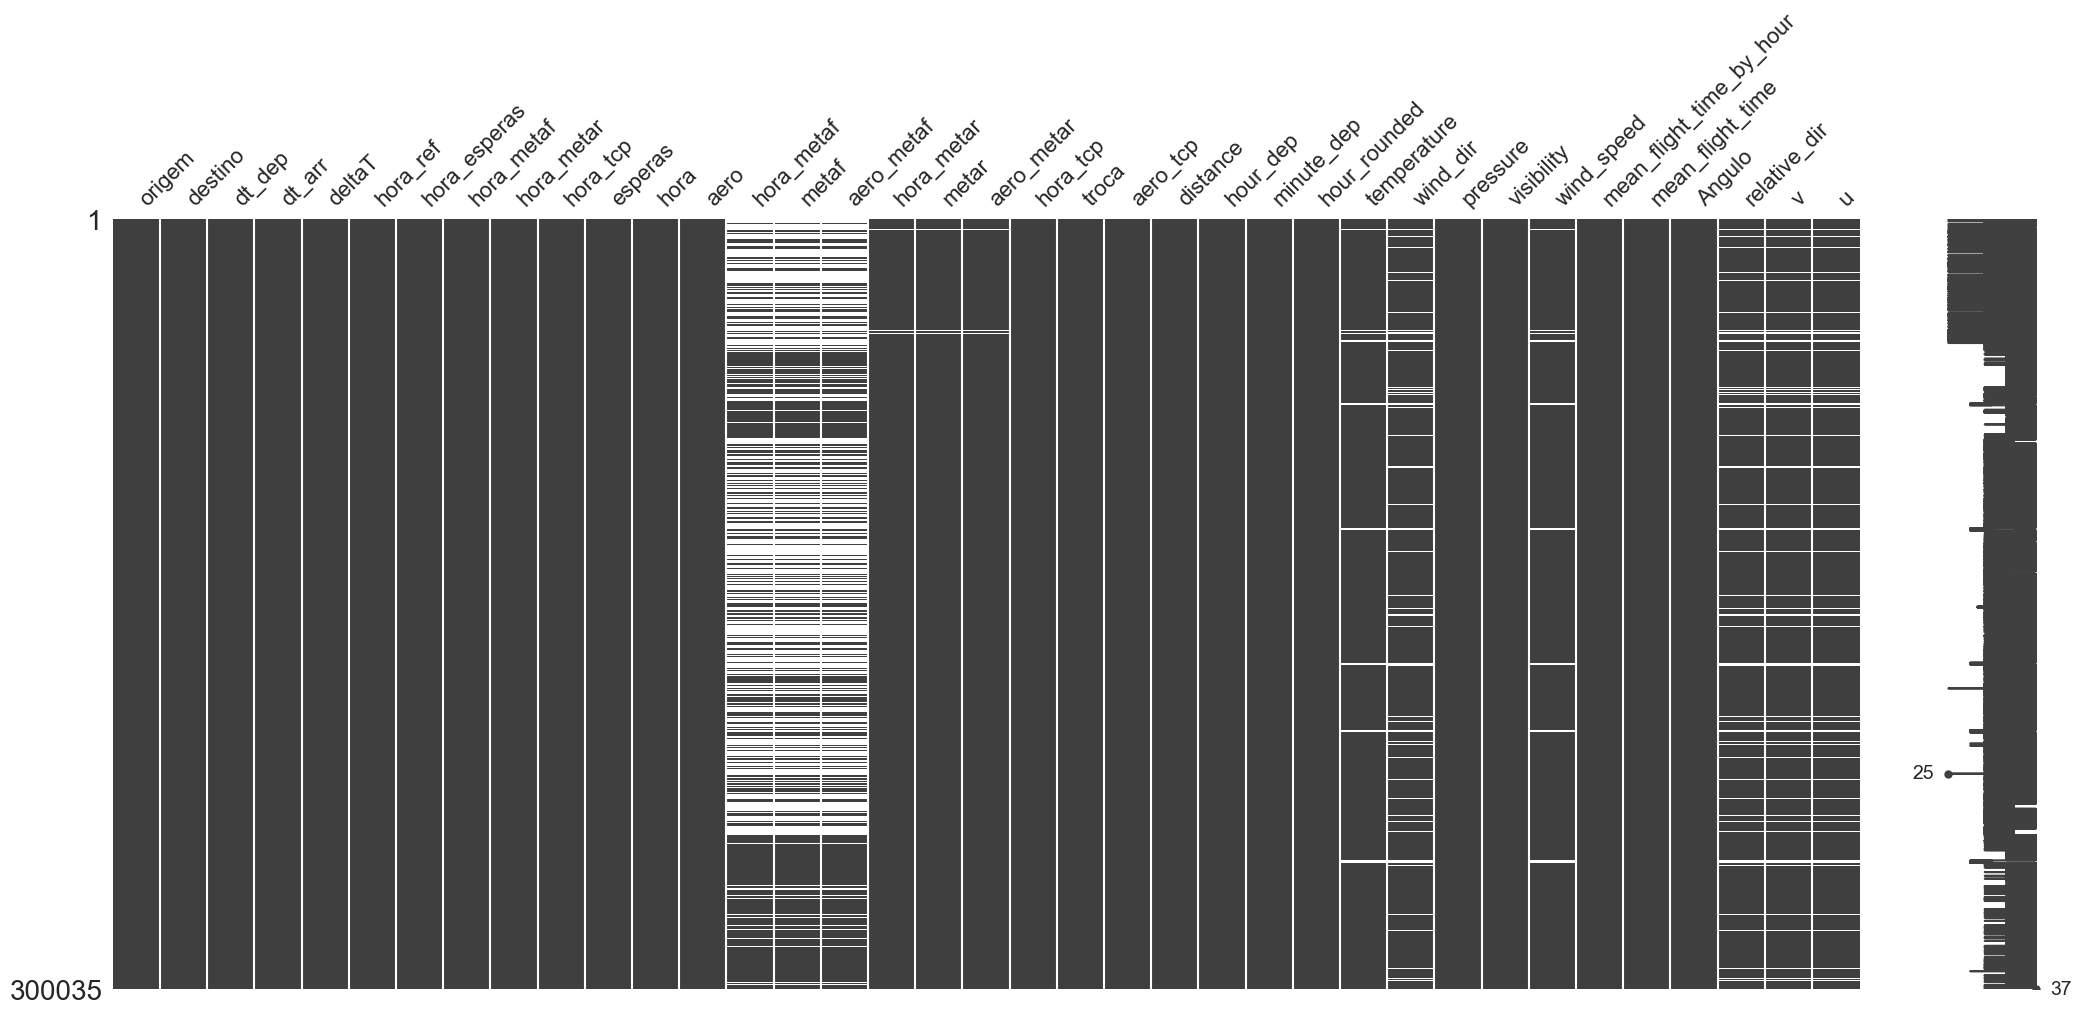

In [22]:
def wind_speed(metar):
    try:
        return Metar.Metar(metar).wind_speed._value 
    except:
        return np.nan
    
def vis_distance(metar):
    try:
        return Metar.Metar(metar).vis._value
    except:
        return np.nan
    
def temperature(metar):
    try:
        return Metar.Metar(metar).temp._value
    except:
        return np.nan
    
def dew_point(metar):
    try:
        return Metar.Metar(metar).dewpt._value
    except:
        return np.nan
    
def wind_dir(metar):
    try:
        return Metar.Metar(metar).wind_dir._degrees
    except:
        return np.nan

def pressure(metar):
    try:
        return Metar.Metar(metar).press._value
    except:
        return np.nan
    
def clouds(metar):
    try:
        return Metar.Metar(metar).sky
    except:
        return np.nan

def calcular_angulo(row, aeroportos):
    aeroporto_origem = row['origem']
    aeroporto_chegada = row['destino']

    lat_lon_origem = aeroportos[aeroporto_origem]
    lat_lon_chegada = aeroportos[aeroporto_chegada]

    lat1, lon1 = lat_lon_origem
    lat2, lon2 = lat_lon_chegada

    angulo_radianos = math.atan2(lat2 - lat1, lon2 - lon1)
    angulo_graus = math.degrees(angulo_radianos) % 360

    return angulo_graus

data_raw['temperature'] = data_raw.apply(lambda row: temperature(row['metar']), axis=1)
print('temperature')

data_raw['wind_dir'] = data_raw.apply(lambda row: wind_dir(row['metar']), axis=1)
print('wind_dir')

data_raw['pressure'] = data_raw.apply(lambda row: pressure(row['metar']), axis=1)

data_raw['visibility'] = data_raw.apply(lambda row: vis_distance(row['metar']), axis=1)
data_raw['wind_speed'] = data_raw.apply(lambda row: wind_speed(row['metar']), axis=1)
print('wind_speed')


def categorizar(valor):
    if valor > 5000:
        return 1
    else:
        return 0
    
data_raw['visibility'] = data_raw['visibility'].map(categorizar)

def replace_value(value):
    if value is np.nan:
        return 0
    else:
        return 1

def len_clouds(value):
    return value.count(")")

data_raw['pressure'] = data_raw['pressure'].fillna(1000.0)

data_raw = data_raw.merge(mean_time_by_hour, on=['origem', 'destino','hour_rounded'], how='left')
data_raw = data_raw.merge(mean_time_df, on=['origem', 'destino'], how='left')

# Aplicar a função calcular_angulo a cada linha do DataFrame
data_raw['Angulo'] = data_raw.apply(calcular_angulo, args=(AEROPORTOS,), axis=1)

data_raw['relative_dir'] =  180 - abs( 180 - abs(data_raw['Angulo']- data_raw['wind_dir']))

data_raw['v'] = data_raw['wind_speed'] * np.cos(data_raw['relative_dir']*np.pi/180)
data_raw['u'] = data_raw['wind_speed'] * np.sin(data_raw['relative_dir']*np.pi/180)

msno.matrix(data_raw)
plt.show()

In [25]:
data_raw = data_raw[['origem', 'destino', 'dt_dep', 'dt_arr', 'deltaT',
    'esperas', 'metaf', 'metar', 'troca', 'distance', 'hour_dep', 'minute_dep',
    'hour_rounded', 'temperature', 'wind_dir', 'pressure', 'visibility',
    'wind_speed', 'mean_flight_time_by_hour', 'mean_flight_time', 'Angulo',
    'relative_dir', 'v', 'u']]
print(f'Possible Columns: {data_raw.columns.values}')

Possible Columns: ['origem' 'destino' 'dt_dep' 'dt_arr' 'deltaT' 'esperas' 'metaf' 'metar'
 'troca' 'distance' 'hour_dep' 'minute_dep' 'hour_rounded' 'temperature'
 'wind_dir' 'pressure' 'visibility' 'wind_speed'
 'mean_flight_time_by_hour' 'mean_flight_time' 'Angulo' 'relative_dir' 'v'
 'u']


In [26]:
cols = ['deltaT', 'esperas', 'troca', 'distance', 'v', 'u', 'temperature', 'mean_flight_time', 'hour_rounded']

data_raw = data_raw[cols].copy()

data_raw['esperas'] = data_raw['esperas'].fillna(0)
data_raw = data_raw.fillna(method='ffill')

print(data_raw.info())
X =  data_raw.drop(['deltaT'], axis=1)
y =  data_raw['deltaT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300035 entries, 0 to 300034
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   deltaT            300035 non-null  float64
 1   esperas           300035 non-null  float64
 2   troca             300035 non-null  float64
 3   distance          300035 non-null  float64
 4   v                 300035 non-null  float64
 5   u                 300035 non-null  float64
 6   temperature       300035 non-null  float64
 7   mean_flight_time  300035 non-null  float64
 8   hour_rounded      300035 non-null  int32  
dtypes: float64(8), int32(1)
memory usage: 21.7 MB
None


,esperas,troca,distance,v,u,temperature,mean_flight_time,hour_rounded
67828,0.0,0.0,495.202334,-4.991338,0.294190,22.0,3293.678022,15
225404,0.0,1.0,1120.030343,-5.727447,10.544968,29.0,5587.628200,19
3275,0.0,0.0,2100.572404,-1.716576,13.894365,29.0,9718.456070,16
78432,0.0,0.0,359.678450,-2.224539,2.012816,14.0,2640.613006,2
282691,0.0,0.0,837.607091,-3.614941,1.712368,18.0,4770.149927,10
...,...,...,...,...,...,...,...,...
119879,0.0,0.0,872.709147,5.695176,6.968858,28.0,5031.253341,21
259178,1.0,0.0,398.439389,5.458198,10.686818,19.0,3272.565919,9
131932,0.0,0.0,1223.191882,1.211817,11.938656,26.0,6793.207527,20
146867,0.0,1.0,837.607091,-4.996475,0.187722,25.0,4679.797520,17


In [27]:
X_train[X_train['distance']==0]

,esperas,troca,distance,v,u,temperature,mean_flight_time,hour_rounded
149910,0.0,0.0,0.0,-3.464102e+00,2.000000,23.0,0.0,5
141433,0.0,0.0,0.0,-4.499513e+00,5.362311,24.0,0.0,14
108904,0.0,1.0,0.0,-3.758770e+00,1.368081,19.0,0.0,13
166198,2.0,0.0,0.0,5.510911e-16,9.000000,24.0,0.0,15
246118,0.0,0.0,0.0,-1.125833e+01,6.500000,28.0,0.0,19
...,...,...,...,...,...,...,...,...
141439,0.0,0.0,0.0,-4.499513e+00,5.362311,24.0,0.0,13
13731,0.0,0.0,0.0,2.394141e+00,6.577848,18.0,0.0,19
31728,0.0,1.0,0.0,9.000000e+00,0.000000,18.0,0.0,3
236187,0.0,0.0,0.0,2.024848e+00,6.700745,28.0,0.0,18


In [28]:
# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=120, max_depth=15, max_features=0.75, min_samples_leaf=3, random_state=42)

# Train model in train set
rf_regressor.fit(X_train, y_train)

# Predict values in test and train sets
y_pred = rf_regressor.predict(X_test)
y_pred_train = rf_regressor.predict(X_train)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)

print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"Erro Quadrático Médio Train Set (MSE): {mse_train}")
print(f"RMSE: {rmse}")

Erro Quadrático Médio (MSE): 143170.2032736136
Erro Quadrático Médio Train Set (MSE): 111707.51461377813
RMSE: 378.3783863721785


<AxesSubplot:xlabel='mean_flight_time', ylabel='deltaT'>

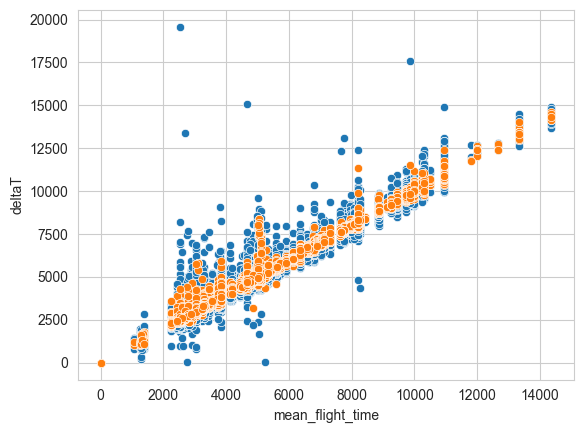

In [29]:
sns.scatterplot(y=y_test, x=X_test['mean_flight_time'])
sns.scatterplot(y=y_pred, x=X_test['mean_flight_time'])

In [30]:
# Calculate erros
erros = (y_test - y_pred)/(3600)

# Create a DataFrame with predictions, actual values and errors
df_resultados = pd.DataFrame({'Previsões': y_pred, 'Valores Reais': y_test, 'Erros': erros})
df_resultados['erro_minutos'] = df_resultados['Erros']*60

df_resultados

,Previsões,Valores Reais,Erros,erro_minutos
125171,10287.980801,10385.0,0.026950,1.616987
7575,6859.134003,6943.0,0.023296,1.397767
254675,2425.325827,2285.0,-0.038979,-2.338764
6581,6143.870018,6031.0,-0.031353,-1.881167
162607,4693.307657,5021.0,0.091026,5.461539
...,...,...,...,...
145010,7623.691808,7858.0,0.065086,3.905137
115537,2832.684938,2707.0,-0.034912,-2.094749
293682,9609.967433,9316.0,-0.081658,-4.899457
103503,3333.015430,3033.0,-0.083338,-5.000257


In [31]:
# Print most discrepant predicted values
threshold = 30  # minutes

mask = (df_resultados['erro_minutos']>=threshold) | (df_resultados['erro_minutos']<=-threshold)
erros_index = df_resultados[mask].index
df_resultados[mask].sort_values(by='erro_minutos')

,Previsões,Valores Reais,Erros,erro_minutos
202933,7306.886528,2859.0,-1.235524,-74.131442
77307,4355.140683,22.0,-1.203650,-72.219011
74805,8313.925454,4341.0,-1.103590,-66.215424
246045,5516.177378,1684.0,-1.064494,-63.869623
128790,7961.475539,4806.0,-0.876521,-52.591259
...,...,...,...,...
182765,2528.559562,8196.0,1.574289,94.457341
260651,11507.139854,17580.0,1.686906,101.214336
197068,4761.806739,15094.0,2.870054,172.203221
205568,2713.892502,13383.0,2.963641,177.818458


In [32]:
check = X_test.loc[erros_index]
check

,esperas,troca,distance,v,u,temperature,mean_flight_time,hour_rounded
202254,2.0,1.0,365.627841,0.947003,2.846609,27.0,2522.659080,0
158581,0.0,0.0,866.126835,0.229009,2.991246,17.0,5125.794252,2
210297,3.0,1.0,365.627841,3.156677,9.488698,22.0,3051.544548,19
213941,0.0,0.0,406.747989,10.243174,6.251190,25.0,2877.490949,1
831,1.0,0.0,523.786163,-6.857774,1.403899,16.0,3839.685718,9
...,...,...,...,...,...,...,...,...
93764,0.0,0.0,591.874898,1.609848,1.186756,29.0,3715.400313,21
149745,0.0,1.0,959.134792,-7.793415,4.501408,26.0,5263.313246,18
140864,0.0,1.0,872.709147,-6.999411,0.090796,23.0,5031.253341,21
174795,0.0,0.0,649.950700,4.206602,4.278376,27.0,3812.702273,2


<AxesSubplot:title={'center':'Feature Importance de um Random Forest'}, xlabel='Importância das Características'>

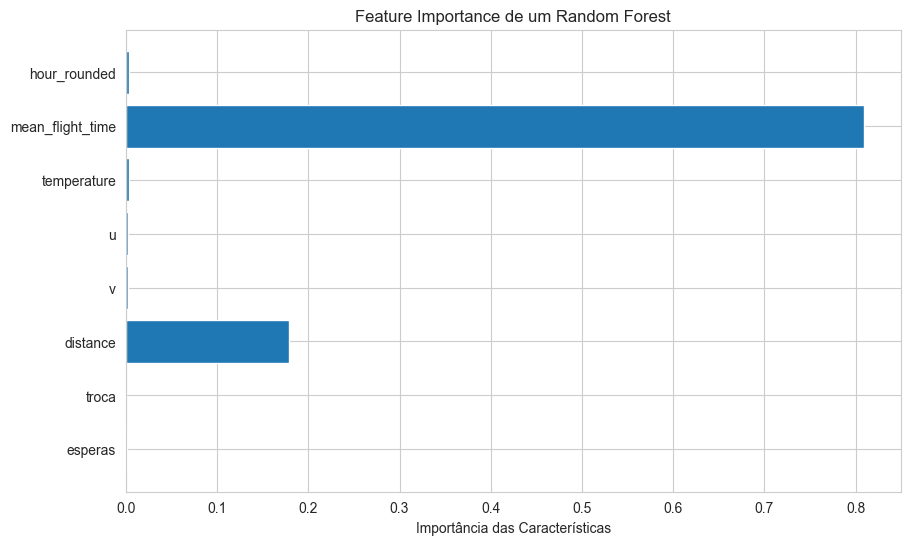

In [33]:
# Get the importance of the features from RandomForestRegressor
feature_importances = rf_regressor.feature_importances_
feature_names = X_train.columns

# Create a bar chart to show the feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(np.arange(len(feature_importances)), feature_names)
plt.xlabel('Importância das Características')
plt.title('Feature Importance de um Random Forest')
plt.gca()

# Calculate for submission data

In [34]:
data_test = pd.read_csv('data/idsc_dataset.csv', sep=';')

data_test['metar'].fillna(method='ffill', inplace=True)
data_test['metar'] = data_test['metar'].apply(lambda x: x[:11]+'30'+x[13:] if x[11:13]=='31' else x)

data_test['distance'] = data_test.apply(calcular_distancia, axis=1)

temperature
wind_dir
wind_speed


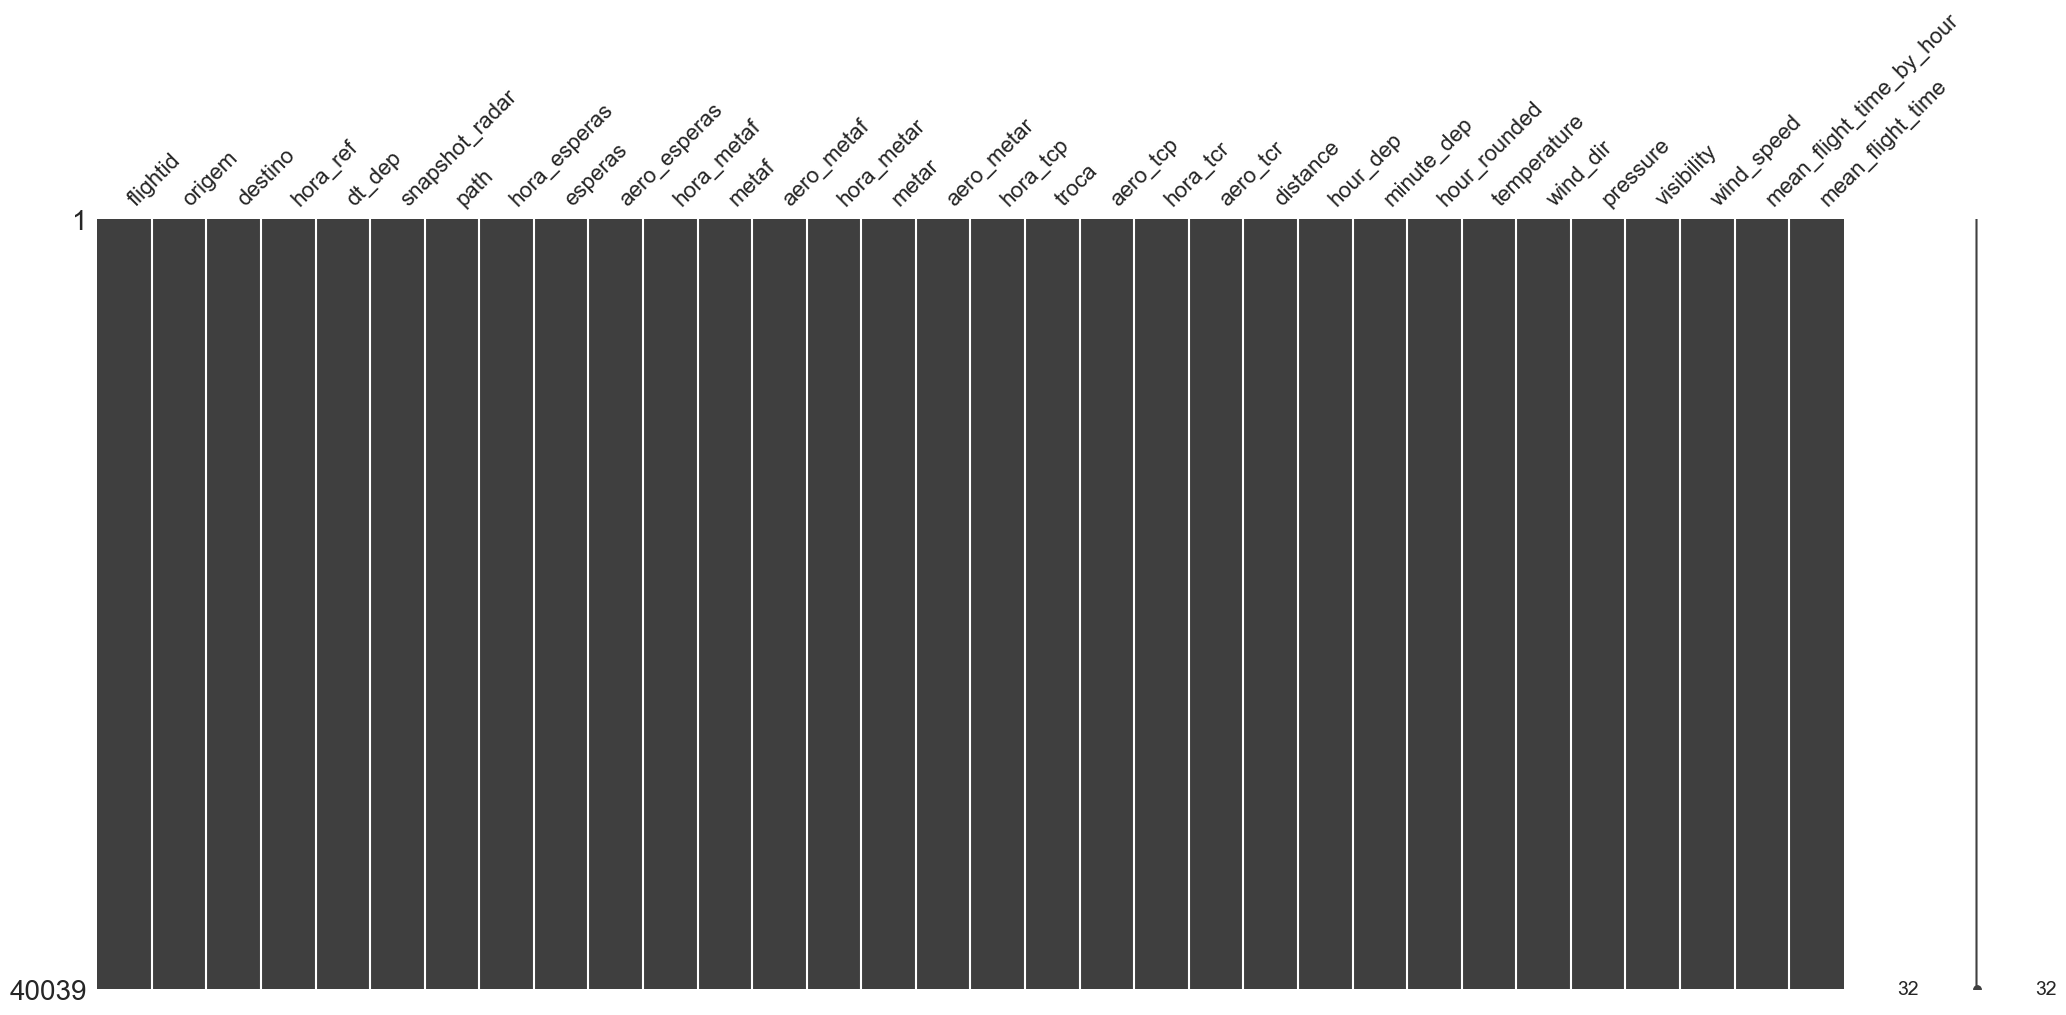

In [35]:
data_test['dt_dep'] = pd.to_datetime(data_test['dt_dep'])
data_test['hour_dep'] = data_test['dt_dep'].dt.hour
data_test['minute_dep'] = data_test['dt_dep'].dt.minute
data_test['hour_rounded'] = round((data_test['hour_dep']*60 + data_test['minute_dep'])/60, 0)
data_test['hour_rounded'] = data_test['hour_rounded'].astype('int')

def wind_speed(metar):
    try:
        return Metar.Metar(metar).wind_speed._value 
    except:
        return np.nan
    
def vis_distance(metar):
    try:
        return Metar.Metar(metar).vis._value
    except:
        return np.nan
    
def temperature(metar):
    try:
        return Metar.Metar(metar).temp._value
    except:
        return np.nan
    
def dew_point(metar):
    try:
        return Metar.Metar(metar).dewpt._value
    except:
        return np.nan
    
def wind_dir(metar):
    try:
        return Metar.Metar(metar).wind_dir._degrees
    except:
        return np.nan

def pressure(metar):
    try:
        return Metar.Metar(metar).press._value
    except:
        return np.nan
    
def clouds(metar):
    try:
        return Metar.Metar(metar).sky
    except:
        return np.nan

def calcular_angulo(row, aeroportos):
    aeroporto_origem = row['origem']
    aeroporto_chegada = row['destino']

    lat_lon_origem = aeroportos[aeroporto_origem]
    lat_lon_chegada = aeroportos[aeroporto_chegada]

    lat1, lon1 = lat_lon_origem
    lat2, lon2 = lat_lon_chegada

    angulo_radianos = math.atan2(lat2 - lat1, lon2 - lon1)
    angulo_graus = math.degrees(angulo_radianos) % 360

    return angulo_graus
data_test['temperature'] = data_test.apply(lambda row: temperature(row['metar']), axis=1)
print('temperature')

data_test['wind_dir'] = data_test.apply(lambda row: wind_dir(row['metar']), axis=1)
print('wind_dir')

data_test['pressure'] = data_test.apply(lambda row: pressure(row['metar']), axis=1)


data_test['visibility'] = data_test.apply(lambda row: vis_distance(row['metar']), axis=1)
data_test['wind_speed'] = data_test.apply(lambda row: wind_speed(row['metar']), axis=1)
print('wind_speed')


def categorizar(valor):
    if valor > 5000:
        return 1
    else:
        return 0
    
data_test['visibility'] = data_test['visibility'].map(categorizar)

def replace_value(value):
    if value is np.nan:
        return 0
    else:
        return 1

def len_clouds(value):
    return value.count(")")

data_test['pressure'] = data_test['pressure'].fillna(1000.0)

data_test = data_test.merge(mean_time_by_hour, on=['origem', 'destino','hour_rounded'], how='left')
data_test = data_test.merge(mean_time_df, on=['origem', 'destino'], how='left')

data_test['mean_flight_time_by_hour']=data_test['mean_flight_time_by_hour'].fillna(data_test['mean_flight_time'])
data_test=data_test.fillna(0)

# Aplicar a função calcular_angulo a cada linha do DataFrame
data_test['Angulo'] = data_test.apply(calcular_angulo, args=(AEROPORTOS,), axis=1)

data_test['relative_dir'] =  180 - abs( 180 - abs(data_test['Angulo']- data_test['wind_dir']))

data_test['v'] = data_test['wind_speed'] * np.cos(data_test['relative_dir']*np.pi/180)
data_test['u'] = data_test['wind_speed'] * np.sin(data_test['relative_dir']*np.pi/180)

msno.matrix(data_test)
plt.show()

In [36]:
data_test[data_test['mean_flight_time_by_hour'].isna()]

,flightid,origem,destino,hora_ref,dt_dep,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,wind_dir,pressure,visibility,wind_speed,mean_flight_time_by_hour,mean_flight_time,Angulo,relative_dir,v,u


In [37]:
cols = [x for x in cols if x != 'deltaT']
X_submission =  data_test[cols]
display(X_submission)

y_pred = rf_regressor.predict(X_submission)

y_pred

,esperas,troca,distance,v,u,temperature,mean_flight_time,hour_rounded
0,1,0.0,872.709147,3.421074,6.107066,18.0,5031.253341,12
1,0,0.0,331.045035,0.250329,4.993730,11.0,2432.954901,0
2,0,0.0,866.126835,-3.852237,1.077158,21.0,5044.684533,2
3,0,0.0,1804.723136,8.844491,1.665825,25.0,8424.911765,4
4,0,0.0,342.948013,-2.514777,3.110610,23.0,2760.717105,0
...,...,...,...,...,...,...,...,...
40034,0,0.0,649.950700,-10.695941,10.516504,27.0,3812.702273,20
40035,0,0.0,331.045035,1.594531,1.207258,19.0,2791.178259,9
40036,0,0.0,495.202334,-0.693874,2.918654,13.0,3032.217499,12
40037,0,0.0,854.437636,-1.311374,3.778928,25.0,4672.914032,12


array([5018.63702682, 2461.28704267, 4962.13220553, ..., 2901.40721233,
       4636.79389526, 5031.68213109])

In [38]:
data_submission = data_test[['flightid']].copy()
data_submission['solution'] = y_pred

data_submission = data_submission.rename(columns={'flightid':'ID'})

#data_submission['solution'] = data_submission['solution'].astype('int')
data_submission

,ID,solution
0,4f0356600f61e3fcbea8ed8a137a2423,5018.637027
1,865dbbbe74bebea18a71f24342516ff0,2461.287043
2,1803af9cfc6a2c74d188481e3ffd848e,4962.132206
3,f6af733a687f904183efd149ec713be5,8296.304446
4,6117f9ac60b7f66b740c9130be433313,2738.792656
...,...,...
40034,4e08052066073297c7a3c55798618324,3859.001069
40035,e22f120c65f5759aa8df576b59d71be3,2520.313602
40036,ca9399162037201a4d0c49c832a32739,2901.407212
40037,560136088f5f1493dbad809a3554172c,4636.793895


In [39]:
# Export to submission csv file
data_submission.to_csv('submission/oficial.csv', index=False)